In [1]:
import numpy as np  
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import pandas.api.types 
import sklearn.metrics 
import nibabel as nib
import os 
import pydicom
from glob import glob
from tqdm import tqdm, trange

In [2]:
file_path = "/kaggle/input/rsna-2023-abdominal-trauma-detection"
Target_cols = ["bowel_healthy", "bowel_injury", "extravasation_healthy",
               "extravasation_injury", "kidney_healthy", "kidney_low",
               "kidney_high", "liver_healthy", "liver_low", "liver_high",
               "spleen_healthy", "spleen_low", "spleen_high", "any_injury"]

In [3]:
file_path = "/kaggle/input/rsna-2023-abdominal-trauma-detection"
train_csv = f"{file_path}/train.csv"
train = pd.read_csv(train_csv)
train.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1


In [4]:
print(train.isnull().sum())

print(train.shape)

print(train.info())

patient_id               0
bowel_healthy            0
bowel_injury             0
extravasation_healthy    0
extravasation_injury     0
kidney_healthy           0
kidney_low               0
kidney_high              0
liver_healthy            0
liver_low                0
liver_high               0
spleen_healthy           0
spleen_low               0
spleen_high              0
any_injury               0
dtype: int64
(3147, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3147 entries, 0 to 3146
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   patient_id             3147 non-null   int64
 1   bowel_healthy          3147 non-null   int64
 2   bowel_injury           3147 non-null   int64
 3   extravasation_healthy  3147 non-null   int64
 4   extravasation_injury   3147 non-null   int64
 5   kidney_healthy         3147 non-null   int64
 6   kidney_low             3147 non-null   int64
 7   kidney_hi

In [5]:
f = train.describe()
mean_values = f.iloc[1]
train.apply(np.max)

patient_id               65508
bowel_healthy                1
bowel_injury                 1
extravasation_healthy        1
extravasation_injury         1
kidney_healthy               1
kidney_low                   1
kidney_high                  1
liver_healthy                1
liver_low                    1
liver_high                   1
spleen_healthy               1
spleen_low                   1
spleen_high                  1
any_injury                   1
dtype: int64

Text(0.5, 1.0, 'Correlation Heatmap for healthy organs')

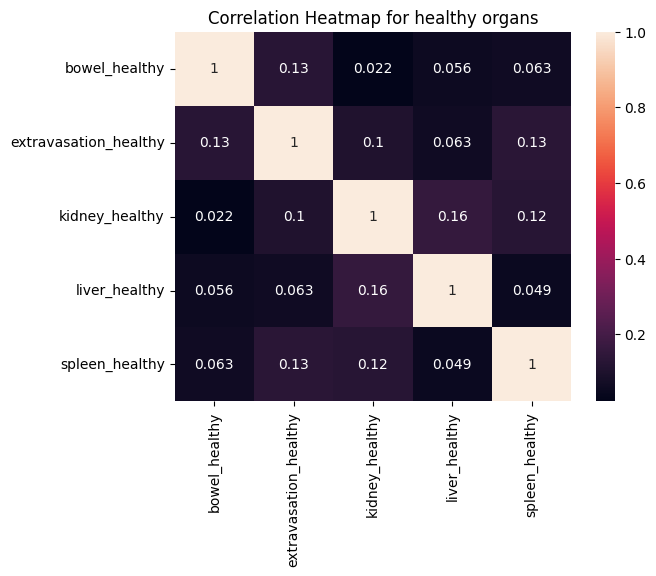

In [6]:
organs_healthy = [
    'bowel_healthy',
    'extravasation_healthy',
    'kidney_healthy',
    'liver_healthy',
    'spleen_healthy'
]
corr_matrix1 = train[organs_healthy].corr()
sns.heatmap(corr_matrix1, annot=True)
plt.title('Correlation Heatmap for healthy organs')

Text(0.5, 1.0, 'Correlation Heatmap for Injury Organs')

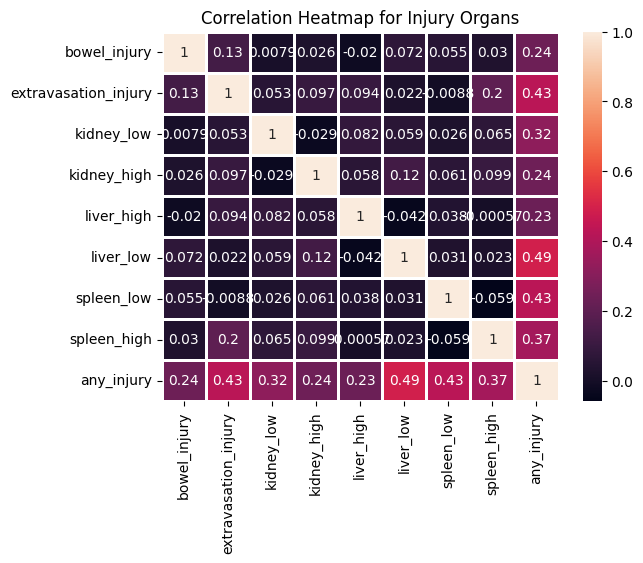

In [7]:
low_high = [
    'bowel_injury',
    'extravasation_injury',
    'kidney_low',
    'kidney_high',
    'liver_high',
    'liver_low',
    'spleen_low',
    'spleen_high',
    'any_injury'
]
corr_matrix2 = train[low_high].corr()
sns.heatmap(corr_matrix2, annot=True, linewidths=1)
plt.title('Correlation Heatmap for Injury Organs')


In [8]:
train_series_meta = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train_series_meta.csv')
train_series_meta.head()
print(train_series_meta.info())
print(train_series_meta.isnull().sum())
f = train_series_meta.describe()
f.iloc[1]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4711 entries, 0 to 4710
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   patient_id        4711 non-null   int64  
 1   series_id         4711 non-null   int64  
 2   aortic_hu         4711 non-null   float64
 3   incomplete_organ  4711 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 147.3 KB
None
patient_id          0
series_id           0
aortic_hu           0
incomplete_organ    0
dtype: int64


patient_id          32722.826788
series_id           32661.752494
aortic_hu             223.622373
incomplete_organ        0.066440
Name: mean, dtype: float64

In [9]:
test_series_meta=pd.read_csv("/kaggle/input/rsna-2023-abdominal-trauma-detection/test_series_meta.csv") 
test_series_meta.head()

,patient_id,series_id,aortic_hu
0,48843,295,401.25
1,48843,62825,238.00
2,50046,24574,149.00
3,50046,60658,352.00
4,63706,39279,219.00


In [10]:
print(test_series_meta.isnull().sum()) 

f=test_series_meta.describe()
f.iloc[1]

patient_id    0
series_id     0
aortic_hu     0
dtype: int64


patient_id    54198.333333
series_id     38169.333333
aortic_hu       279.708333
Name: mean, dtype: float64

In [11]:
image_labels = pd.read_csv("/kaggle/input/rsna-2023-abdominal-trauma-detection/image_level_labels.csv")
image_labels.head()

,patient_id,series_id,instance_number,injury_name
0,10004,21057,362,Active_Extravasation
1,10004,21057,363,Active_Extravasation
2,10004,21057,364,Active_Extravasation
3,10004,21057,365,Active_Extravasation
4,10004,21057,366,Active_Extravasation


In [12]:
print(image_labels.info())
print(image_labels.isnull().sum())
f = image_labels.describe()
f.iloc[1]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12029 entries, 0 to 12028
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   patient_id       12029 non-null  int64 
 1   series_id        12029 non-null  int64 
 2   instance_number  12029 non-null  int64 
 3   injury_name      12029 non-null  object
dtypes: int64(3), object(1)
memory usage: 376.0+ KB
None
patient_id         0
series_id          0
instance_number    0
injury_name        0
dtype: int64


patient_id         34909.677862
series_id          31188.356056
instance_number      311.704132
Name: mean, dtype: float64

In [13]:
train[Target_cols].describe()

,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
count,3147.000000,3147.000000,3147.000000,3147.000000,3147.000000,3147.000000,3147.000000,3147.000000,3147.000000,3147.000000,3147.000000,3147.000000,3147.000000,3147.000000
mean,0.979663,0.020337,0.936447,0.063553,0.942167,0.036543,0.021290,0.897998,0.082301,0.019701,0.887512,0.063235,0.049253,0.271687
std,0.141172,0.141172,0.243993,0.243993,0.233464,0.187666,0.144373,0.302699,0.274866,0.138994,0.316016,0.243424,0.216431,0.444900
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
class ParticipantVisibleError(Exception):
    pass

def normalize_probabilities_to_one(df: pd.DataFrame, group_columns: list) -> pd.DataFrame:
    # Normalize the sum of each row's probabilities to 100%.
    # 0.75, 0.75 => 0.5, 0.5
    # 0.1, 0.1 => 0.5, 0.5
    row_totals = df[group_columns].sum(axis=1)
    if row_totals.min() == 0:
        raise ParticipantVisibleError('All rows must contain at least one non-zero prediction')
    for col in group_columns:
        df[col] /= row_totals
    return df

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    '''
    Pseudocode:
    1. For every label group (liver, bowel, etc):
        - Normalize the sum of each row's probabilities to 100%.
        - Calculate the sample weighted log loss.
    2. Derive a new any_injury label by taking the max of 1 - p(healthy) for each label group
    3. Calculate the sample weighted log loss for the new label group
    4. Return the average of all of the label group log losses as the final score.
    '''
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    # Run basic QC checks on the inputs
    if not pandas.api.types.is_numeric_dtype(submission.values):
        raise ParticipantVisibleError('All submission values must be numeric')

    if not np.isfinite(submission.values).all():
        raise ParticipantVisibleError('All submission values must be finite')

    if solution.min().min() < 0:
        raise ParticipantVisibleError('All labels must be at least zero')
    if submission.min().min() < 0:
        raise ParticipantVisibleError('All predictions must be at least zero')

    # Calculate the label group log losses
    binary_targets = ['bowel', 'extravasation']
    triple_level_targets = ['kidney', 'liver', 'spleen']
    all_target_categories = binary_targets + triple_level_targets

    label_group_losses = []
    for category in all_target_categories:
        if category in binary_targets:
            col_group = [f'{category}_healthy', f'{category}_injury']
        else:
            col_group = [f'{category}_healthy', f'{category}_low', f'{category}_high']
            
        solution = normalize_probabilities_to_one(solution, col_group)

        for col in col_group:
            if col not in submission.columns:
                raise ParticipantVisibleError(f'Missing submission column {col}')
        submission = normalize_probabilities_to_one(submission, col_group)
        label_group_losses.append(
            sklearn.metrics.log_loss(
                y_true=solution[col_group].values,
                y_pred=submission[col_group].values,
                sample_weight=solution[f'{category}_weight'].values
            )
        )
        
    # Derive a new any_injury label by taking the max of 1 - p(healthy) for each label group
    healthy_cols = [x + '_healthy' for x in all_target_categories]
    any_injury_labels = (1 - solution[healthy_cols]).max(axis=1)
    any_injury_predictions = (1 - submission[healthy_cols]).max(axis=1)
    any_injury_loss = sklearn.metrics.log_loss(
        y_true=any_injury_labels.values,
        y_pred=any_injury_predictions.values,
        sample_weight=solution['any_injury_weight'].values
    )

    label_group_losses.append(any_injury_loss)
    return np.mean(label_group_losses) 

In [15]:
def create_training_solution(y_train):
    sol_train = y_train.copy()
    
    # bowel healthy|injury sample weight = 1|2/1
    sol_train['bowel_weight'] = np.where(sol_train['bowel_injury'] == 1, 2, 1)
    
    # extravasation healthy/injury sample weight = 1|6/1
    sol_train['extravasation_weight'] = np.where(sol_train['extravasation_injury'] == 1, 6, 1)
    
    # kidney healthy|low|high sample weight = 1|2|4
    sol_train['kidney_weight'] = np.where(sol_train['kidney_low'] == 1, 2, np.where(sol_train['kidney_high'] == 1, 4, 1))
    
    # liver healthy|low|high sample weight = 1|2|4
    sol_train['liver_weight'] = np.where(sol_train['liver_low'] == 1, 2, np.where(sol_train['liver_high'] == 1, 4, 1))
    
    # spleen healthy|low|high sample weight = 1|2|4
    sol_train['spleen_weight'] = np.where(sol_train['spleen_low'] == 1, 2, np.where(sol_train['spleen_high'] == 1, 4, 1))
    
    # any healthy|injury sample weight = 1|6/1
    sol_train['any_injury_weight'] = np.where(sol_train['any_injury'] == 1, 6, 1)
    return sol_train

In [16]:
solution_train = create_training_solution(train)

# predict a constant using the mean of the training data
y_pred = train.copy()
y_pred[Target_cols] = train[Target_cols].mean().tolist()

no_scale_score = score(solution_train,y_pred,'patient_id')
print(f'Training score without scaling: {no_scale_score}')

Training score without scaling: 0.7860663285561644


In [17]:
# Group by different sample weights
scale_by_2 = ['kidney_low','liver_low','spleen_low','spleen_high']
scale_by_4 = ['bowel_injury','kidney_high','liver_high']
scale_by_6 = ['extravasation_injury','any_injury']
scale_healthy = ['bowel_healthy', 'extravasation_healthy', 'kidney_healthy', 'liver_healthy', 'spleen_healthy']

sf_2 = 2.8461531332
sf_4 = 4.841531
sf_6 = 20.81635153
scale_h = 0.99519515313

# The score function deletes the ID column so we remake it
solution_train = create_training_solution(train)

# Reset the prediction
y_pred = train.copy()
y_pred[Target_cols] = train[Target_cols].mean().tolist()

# Scale each target 
y_pred[scale_by_2] *=sf_2
y_pred[scale_by_4] *=sf_4
y_pred[scale_by_6] *=sf_6
y_pred[scale_healthy] *=scale_h

weight_scale_score = score(solution_train,y_pred,'patient_id')
print(f'Training score with weight scaling: {weight_scale_score}')

Training score with weight scaling: 0.5940216198703137


In [18]:
solution_train = create_training_solution(train)

y_pred = train.copy()
y_pred[Target_cols] = train[Target_cols].mean().tolist()

y_pred[scale_by_2] *= sf_2
y_pred[scale_by_4] *= sf_4
y_pred[scale_by_6] *= sf_6
y_pred[scale_healthy] *=scale_h

improved_scale_score = score(solution_train, y_pred, 'patient_id')
print(f'Training score with better scaling: {improved_scale_score}')

Training score with better scaling: 0.5940216198703137


In [19]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import nibabel as nib

import os
import pydicom
from glob import glob
from tqdm import tqdm, trange

PATH = '/kaggle/input/rsna-2023-abdominal-trauma-detection'

In [20]:
id = 21057 #input series_id

a = glob(f'{PATH}/segmentations/*.nii')
for i in range(len(a)):
    if (f'{PATH}/segmentations/{id}.nii' == a[i]):
        print('ok')
        break
if i == len(a)-1:
    print('The id does`t extist')

ok


In [21]:
train = pd.read_csv(f'{PATH}/train.csv')

train_series_meta = pd.read_csv(f'{PATH}/train_series_meta.csv')
df = pd.merge(train_series_meta, train, how='inner', on='patient_id')

seg_filepath = f'{PATH}/segmentations/{id}.nii'

patient_id = df[df['series_id'] == id]['patient_id'].iloc[0]
filepath = f'{PATH}/train_images/{patient_id}/{id}'

In [22]:
def create_3D_scans(folder, downsample_rate=1): 
    filenames = os.listdir(folder)
    filenames = [int(filename.split('.')[0]) for filename in filenames]
    filenames = sorted(filenames)
    filenames = [str(filename) + '.dcm' for filename in filenames]
        
    volume = []
    for filename in tqdm(filenames[::downsample_rate]):
        filepath = os.path.join(folder, filename)
        ds = pydicom.dcmread(filepath)
        image = ds.pixel_array
        
        # find rescale params
        if ("RescaleIntercept" in ds) and ("RescaleSlope" in ds):
            intercept = float(ds.RescaleIntercept)
            slope = float(ds.RescaleSlope)
    
        # find clipping params
        center = int(ds.WindowCenter)
        width = int(ds.WindowWidth)
        low = center - width / 2
        high = center + width / 2    
        image = (image * slope) + intercept
        image = np.clip(image, low, high)

        image = (image / np.max(image) * 255).astype(np.int16)
        image = image[::downsample_rate, ::downsample_rate]
        volume.append( image )
    
    volume = np.stack(volume, axis=0)
    return volume

In [23]:
def create_3D_segmentations(filepath, downsample_rate=1):
    img = nib.load(filepath).get_fdata()
    img = np.transpose(img, [2, 1, 0])
    img = np.rot90(img, -1, (1,2))
    img = img[::-1,:,:]
    img = np.transpose(img, [2, 1, 0])
    img = img[::downsample_rate, ::downsample_rate, ::downsample_rate]
    return img

In [24]:
volume = create_3D_scans(filepath)
volume = volume.transpose(1, 2, 0)
volume_seg = create_3D_segmentations(seg_filepath)
volume.shape

100%|██████████| 1022/1022 [00:20<00:00, 48.77it/s]


(512, 512, 1022)

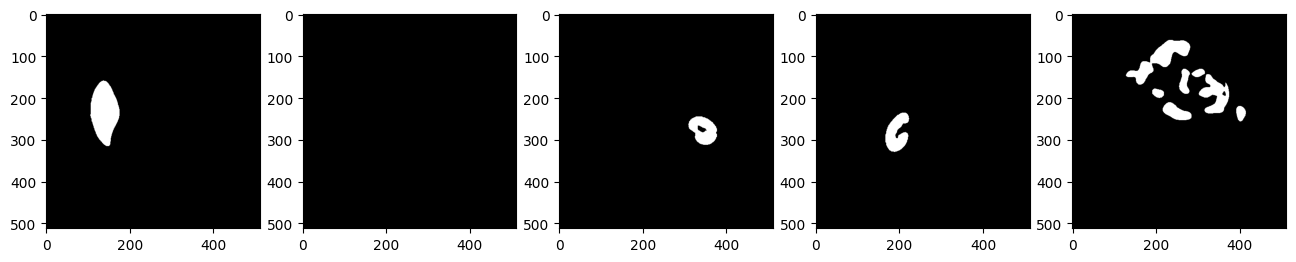

In [25]:
z =500 #slice number
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(151)
ax1.imshow(np.where(volume_seg[:,:,z]==1,1,0), cmap = 'gray') #liver
ax2 = fig.add_subplot(152)
ax2.imshow(np.where(volume_seg[:,:,z]==2,1,0), cmap = 'gray') #spleen
ax3 = fig.add_subplot(153)
ax3.imshow(np.where(volume_seg[:,:,z]==3,1,0), cmap = 'gray') #right kidney
ax4 = fig.add_subplot(154)
ax4.imshow(np.where(volume_seg[:,:,z]==4,1,0), cmap = 'gray') #left kidney
ax5 = fig.add_subplot(155)
ax5.imshow(np.where(volume_seg[:,:,z]==5,1,0), cmap = 'gray') #bowel
plt.show()

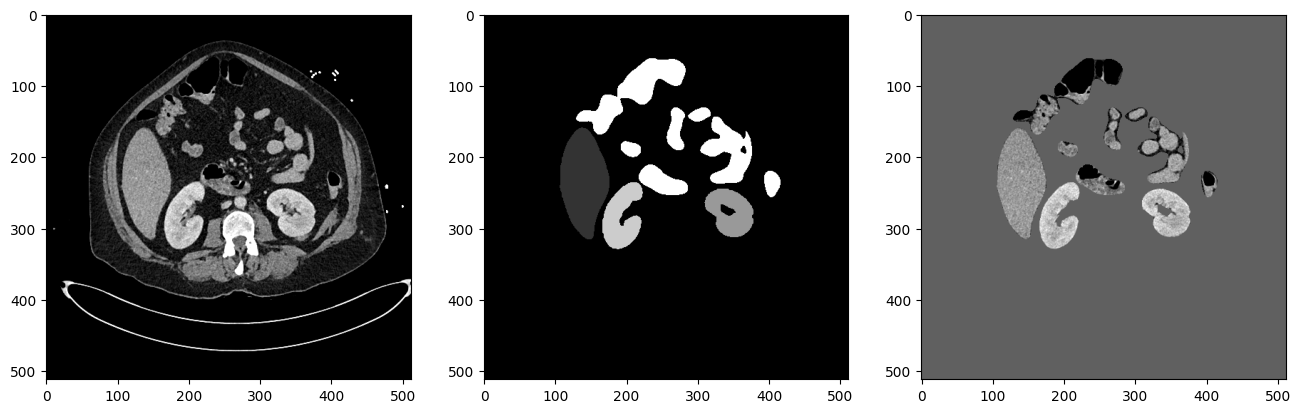

In [26]:
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(131)
ax1.imshow(volume[:,:,z], cmap = 'gray')
ax2 = fig.add_subplot(132)
ax2.imshow(volume_seg[:,:,z], cmap = 'gray')
ax3 = fig.add_subplot(133)
ax3.imshow(volume[:,:,z]*np.where(volume_seg[:,:,z]>0,1,0), cmap = 'gray')
plt.show()

In [27]:
liver_ct = volume*np.where(volume_seg==1,1,0)
spleen_ct = volume*np.where(volume_seg==2,1,0)
r_kidney_ct = volume*np.where(volume_seg==3,1,0)
l_kidney_ct = volume*np.where(volume_seg==4,1,0)
bowel_ct = volume*np.where(volume_seg==5,1,0)

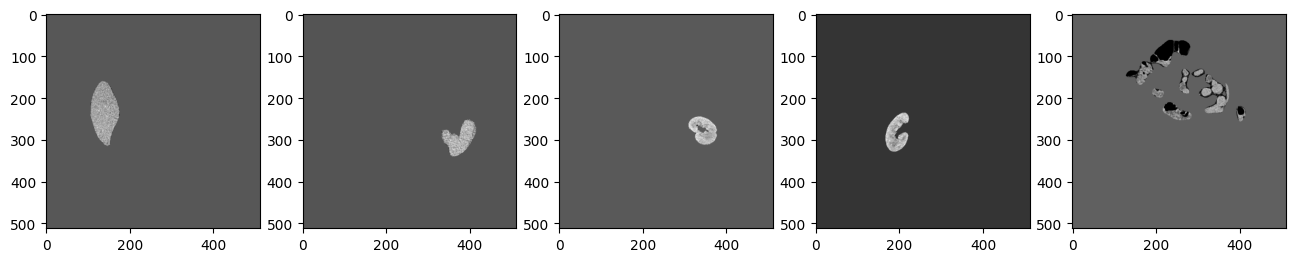

In [28]:
z =500 #slice number
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(151)
ax1.imshow(liver_ct[:,:,z], cmap = 'gray') #liver
ax2 = fig.add_subplot(152)
ax2.imshow(spleen_ct[:,:,380], cmap = 'gray') #spleen
ax3 = fig.add_subplot(153)
ax3.imshow(r_kidney_ct[:,:,z], cmap = 'gray') #right kidney
ax4 = fig.add_subplot(154)
ax4.imshow(l_kidney_ct[:,:,z], cmap = 'gray') #left kidney
ax5 = fig.add_subplot(155)
ax5.imshow(bowel_ct[:,:,z], cmap = 'gray') #bowel
plt.show()

In [29]:
submission = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/sample_submission.csv')
submission[Target_cols] = train[Target_cols].mean().tolist()
submission[scale_by_2] *=sf_2
submission[scale_by_4] *=sf_4
submission[scale_by_6] *=sf_6 
submission[scale_healthy] *=scale_h
submission.to_csv('submission.csv', index=False)